In [24]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from skimage.transform import resize, rescale
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from IPython.display import display
from tensorflow.keras import Input, Model
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from matplotlib import pyplot
import tensorflow as tf
from tensorflow import keras
import numpy as np
np.random.seed(0)
import re
import cv2
import os
import math
import numpy as np

In [14]:
root_dir = os.path.join("data/", "DIV2K_train_HR/")

resize_size = 512
upscale_factor = 2
input_size = resize_size // upscale_factor
batch_size = 10

In [15]:
print(input_size)

256


In [12]:
train_ds = image_dataset_from_directory(
        root_dir,
        batch_size=batch_size,
        image_size=(resize_size, resize_size),
        validation_split=0.2,
        subset="training",
        seed=1337,
        label_mode=None,
)

Found 900 files belonging to 1 classes.
Using 720 files for training.


In [16]:
valid_ds = image_dataset_from_directory(
        root_dir,
        batch_size=batch_size,
        image_size=(resize_size, resize_size),
        validation_split=0.2,
        subset="validation",
        seed=1337,
        label_mode=None,
)

Found 900 files belonging to 1 classes.
Using 180 files for validation.


In [17]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

In [18]:
train_ds = train_ds.map(scaling)

In [19]:
valid_ds = valid_ds.map(scaling)

In [20]:
# Use TF Ops to process.
def process_input(input_x, input_size, upscale_factor):
    return tf.image.resize(input_x, [input_size, input_size], method="area")


def process_target(input_x):
    return input_x

In [21]:
train_ds = train_ds.map(
           lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
          lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)

valid_ds = valid_ds.prefetch(buffer_size=32)

In [45]:
scale_factor=2
input_img = Input(shape=(None, None, 3))
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)   
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding = 'same')(l5) #2

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l6)
l8 = Conv2DTranspose(256, (2,2), strides=(2,2))(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l8)

l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l9)     # 2  /   2 

l11 = add([l5, l10])
l12 = Conv2DTranspose(128, (2,2), strides=(2,2))(l11)

l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l12)

l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])
postUpsampling= Conv2DTranspose(64, (2,2), strides=(2,2))(l15)

X_up = Conv2D(64 * (scale_factor ** 2), 3, padding='same')(l15)
postUpsampling = tf.nn.depth_to_space(X_up, scale_factor)


decoded = Conv2D(3, (3, 3), padding = 'same', 
                 activation = 'relu', activity_regularizer = regularizers.l1(10e-10))(postUpsampling)


autoencoder = Model(input_img, decoded)

In [46]:
autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_33 (Conv2D)             (None, None, None,   1792        ['input_5[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_34 (Conv2D)             (None, None, None,   36928       ['conv2d_33[0][0]']              
                                64)                                                         

In [47]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics='accuracy')

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [49]:
history=autoencoder.fit(train_ds,epochs=80,batch_size=10,shuffle=True, callbacks=[callback],validation_data=valid_ds)

Epoch 1/80
72/72 [==============================] - 976s 13s/step - loss: 0.0256 - accuracy: 0.6152 - val_loss: 0.0060 - val_accuracy: 0.7252
Epoch 2/80
72/72 [==============================] - 974s 13s/step - loss: 0.0056 - accuracy: 0.8279 - val_loss: 0.0044 - val_accuracy: 0.8440
Epoch 3/80
72/72 [==============================] - 972s 13s/step - loss: 0.0048 - accuracy: 0.8599 - val_loss: 0.0041 - val_accuracy: 0.8603
Epoch 4/80
72/72 [==============================] - 974s 13s/step - loss: 0.0046 - accuracy: 0.8705 - val_loss: 0.0039 - val_accuracy: 0.8779
Epoch 5/80
72/72 [==============================] - 973s 13s/step - loss: 0.0044 - accuracy: 0.8712 - val_loss: 0.0038 - val_accuracy: 0.8888
Epoch 6/80
72/72 [==============================] - 975s 13s/step - loss: 0.0042 - accuracy: 0.8840 - val_loss: 0.0037 - val_accuracy: 0.9017
Epoch 7/80
72/72 [==============================] - 974s 13s/step - loss: 0.0043 - accuracy: 0.8856 - val_loss: 0.0041 - val_accuracy: 0.8893
Epoch 

In [50]:
autoencoder.save('Autoencoder_subpixel_ep_10batch_model.h5') 

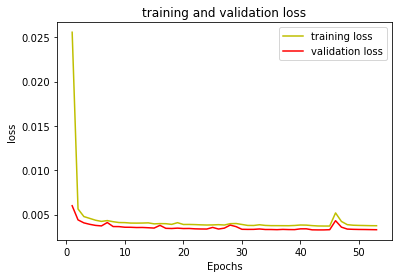

In [51]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

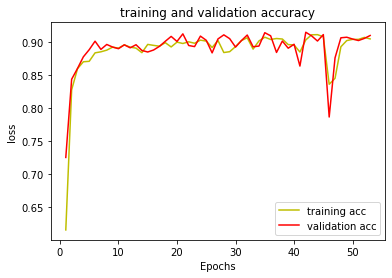

In [52]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [53]:
print(history.history)

{'loss': [0.02555357664823532, 0.00564434053376317, 0.004785572644323111, 0.0045784590765833855, 0.004371095448732376, 0.004240975249558687, 0.004331059753894806, 0.004205331206321716, 0.004112184979021549, 0.004102237056940794, 0.004051520489156246, 0.004046369343996048, 0.00405412632972002, 0.0040761190466582775, 0.003962816670536995, 0.003991218749433756, 0.003981388173997402, 0.003905348014086485, 0.0040951985865831375, 0.0038932866882532835, 0.00389655539765954, 0.0038792146369814873, 0.003851649584248662, 0.0038317060098052025, 0.0038424909580498934, 0.0038727661594748497, 0.003830925328657031, 0.003984138369560242, 0.004002000205218792, 0.0038949029985815287, 0.003786362474784255, 0.003779913065955043, 0.003862610785290599, 0.0037865424528717995, 0.0037618991918861866, 0.003761021653190255, 0.003757425816729665, 0.0037541757337749004, 0.0037808450870215893, 0.0038335018325597048, 0.0038210954517126083, 0.0037642926909029484, 0.0037256896030157804, 0.003717424115166068, 0.0037163